This is a notebook to explore the trained ANNs saved by `create_and_train.py`

In [1]:
try:
    import cPickle as pickle
except:
    import pickle
import glob
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import lasagne
from lasagne import layers
from lasagne import nonlinearities
from nolearn.lasagne import NeuralNet, TrainSplit
from sklearn import preprocessing
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

from create_and_train import EarlyStopping
from constant import Y_COLUMNS
from plotting_utils import plot_one_learning_curve, pplot_one_output
from plotting_utils import hplot_one_output, pplot_one_output_full
from lignet_utils import gen_train_test, load_nets, calc_r_squared
from lignet_utils import print_r_squared, transform_pred_to_actual

%matplotlib inline

In [2]:
x_train, x_test, y_train, y_test, x_scaler, y_scaler = gen_train_test()

nets = load_nets('trained_networks/final*')
full_net = load_nets('trained_networks/full*')

In [2]:
with open('learning_curve.pkl', 'rb') as pkl:
    (train_scores_mean, train_scores_std, valid_scores_mean,
     valid_scores_std, train_sizes) = pickle.load(pkl)

[0, 6000, 0, 1.8]

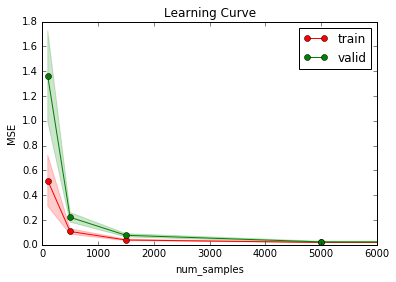

In [6]:
# Make a learning curve (for full_net) to show how much training data is needed
plt.figure()
plt.title('Learning Curve')
plt.xlabel("num_samples")
plt.ylabel("MSE")

plt.plot(train_sizes, -train_scores_mean, 'o-', label='train', color='r')
plt.fill_between(train_sizes, -train_scores_mean - train_scores_std,
                -train_scores_mean + train_scores_std, alpha=0.2, color='r')
plt.plot(train_sizes, -valid_scores_mean, 'o-', label='valid', color='g')
plt.fill_between(train_sizes, -valid_scores_mean - valid_scores_std,
                -valid_scores_mean + valid_scores_std, alpha=0.2, color='g')
plt.legend(loc=0)
plt.axis([0, 6000, 0, 1.8])
# plt.savefig('learning_curve.png')

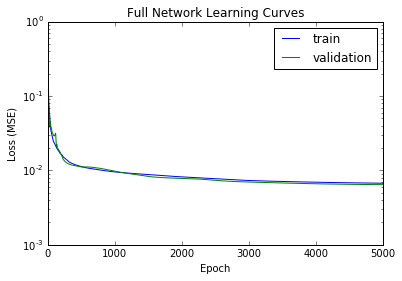

In [3]:
plot_one_learning_curve('all', full_net)

/usr/local/lib/python2.7/site-packages/matplotlib/pyplot.py:516: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


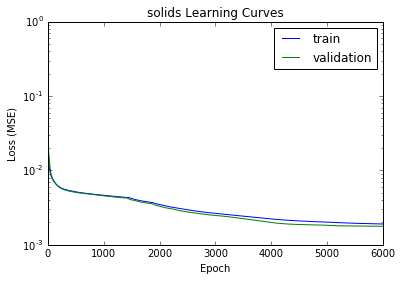

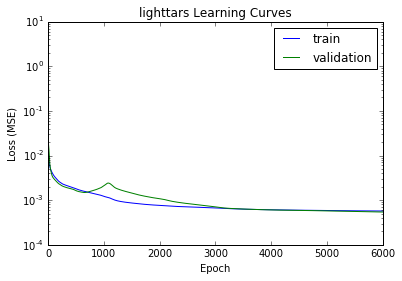

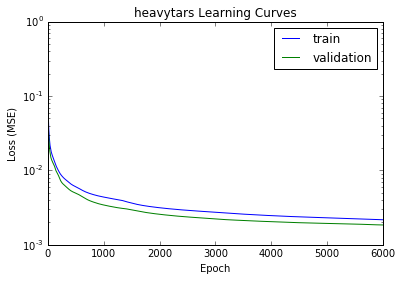

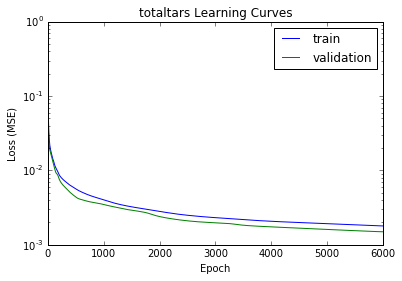

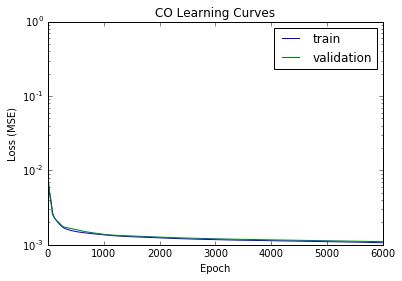

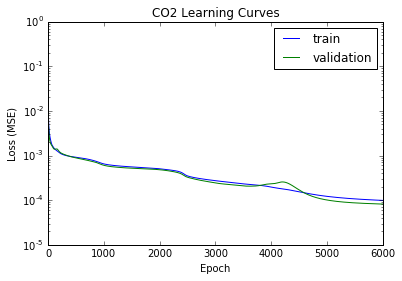

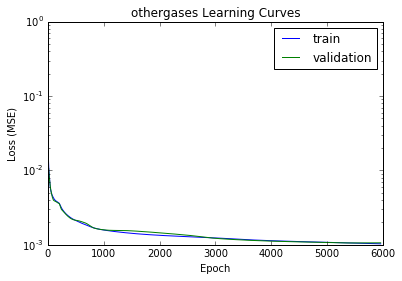

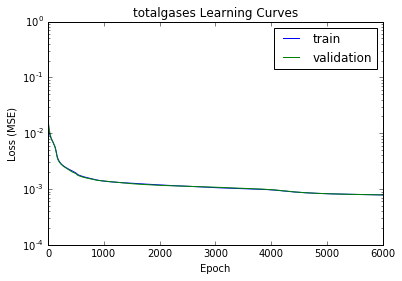

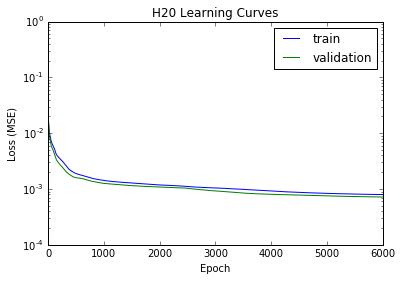

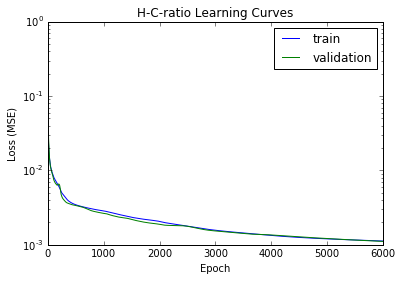

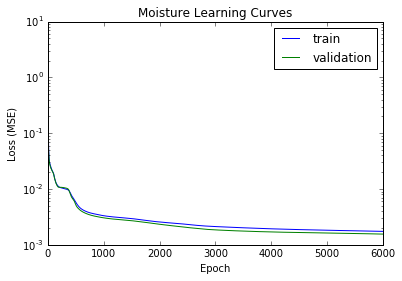

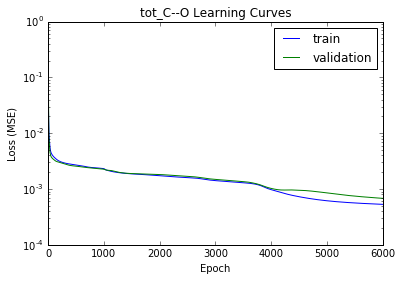

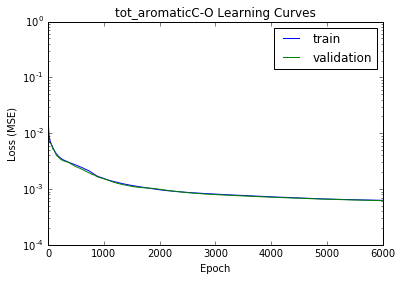

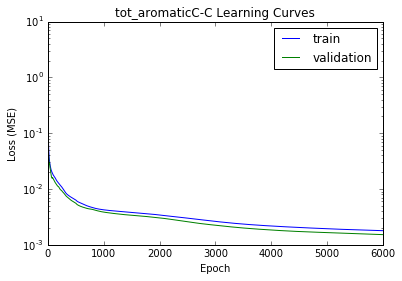

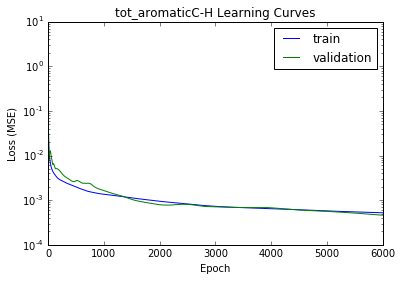

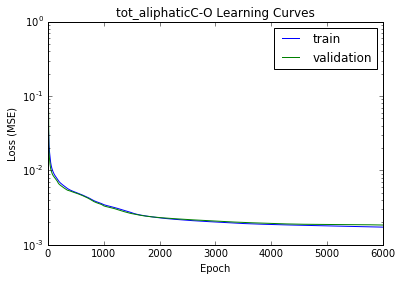

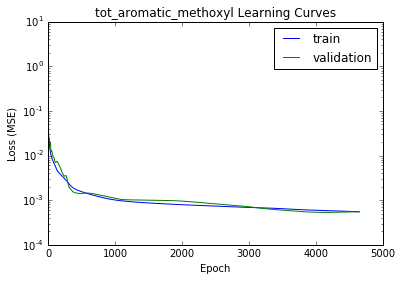

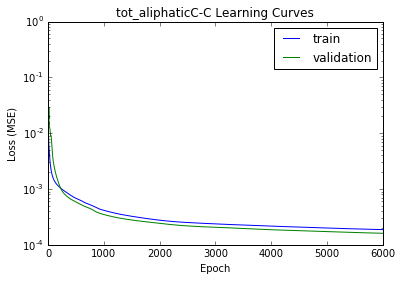

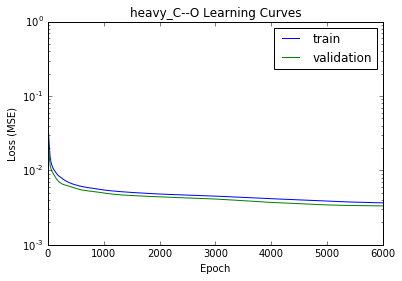

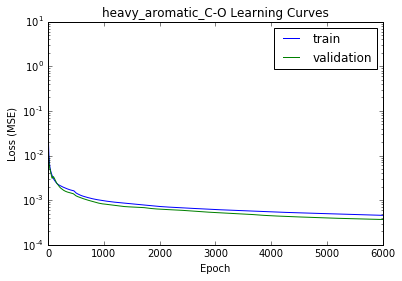

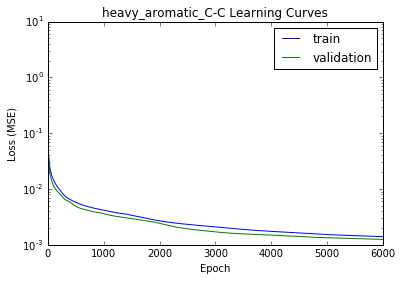

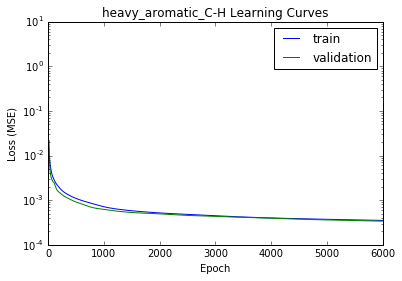

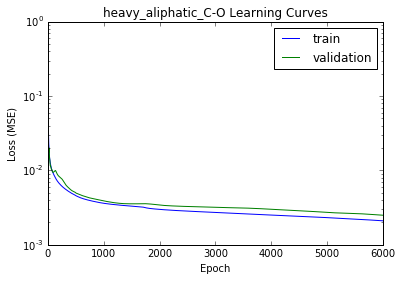

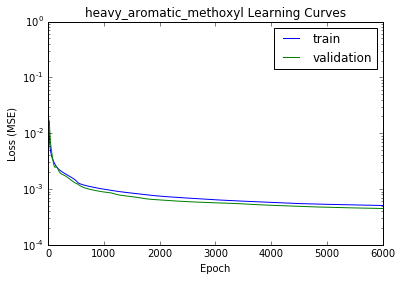

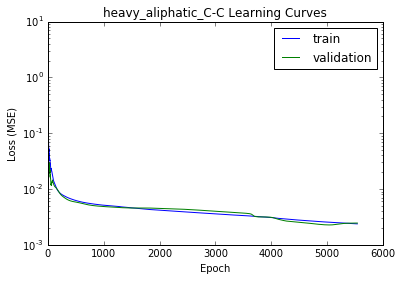

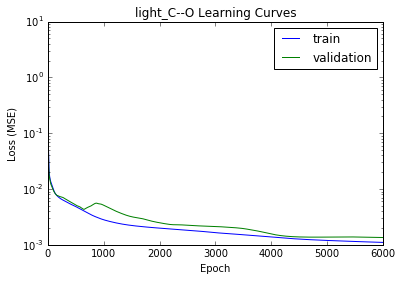

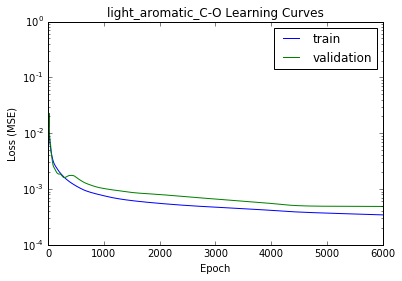

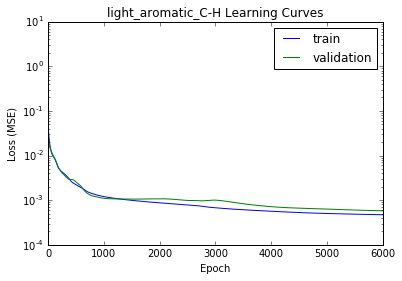

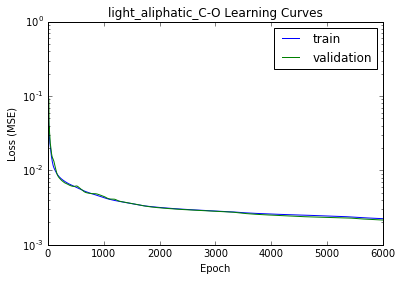

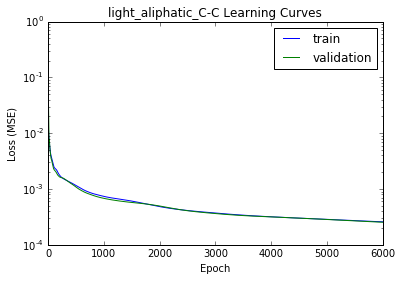

In [3]:
for key in nets:
    plot_one_learning_curve(key, nets)

In [50]:
plt.close('all')

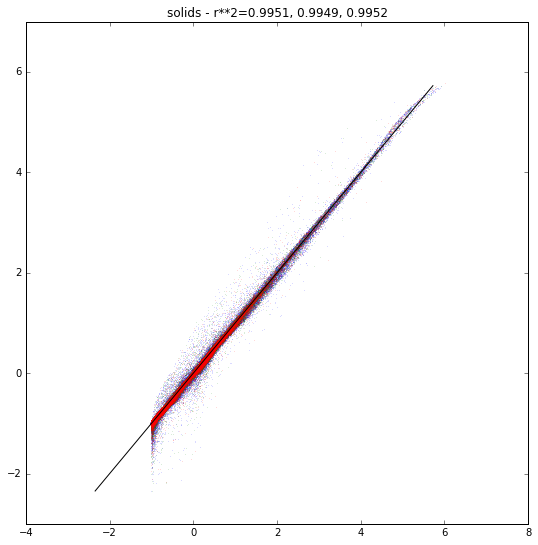

In [4]:
# Plot a single output measure
f, ax = plt.subplots(figsize=(9, 9))
pplot_one_output(ax, nets[0], x_train, y_train, x_test, y_test, 0, Y_COLUMNS[0])

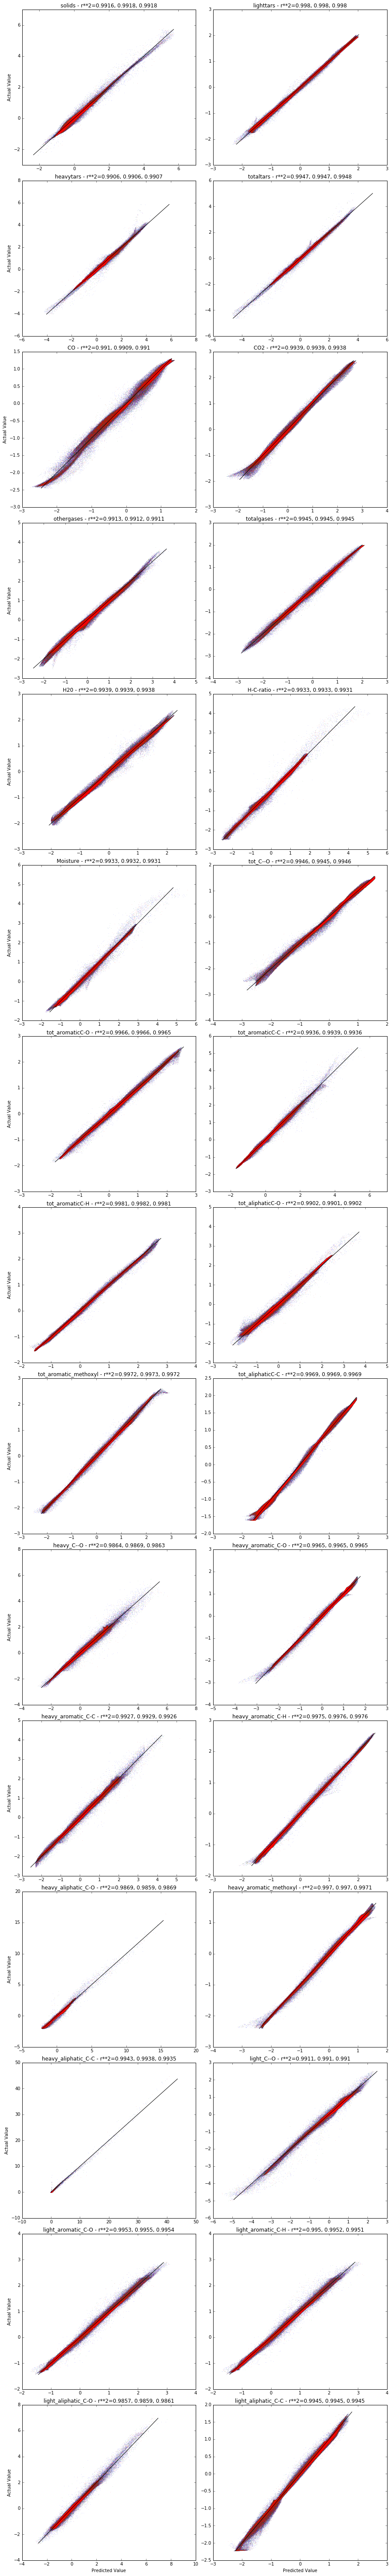

In [4]:
# Parity plots for the output measures in the full network
output_list = nets.keys()
f, ax = plt.subplots(int(round(len(output_list)/2.0)), 2, sharex=False,
                     sharey=False, figsize=(15, 3.5*len(output_list)))
ax = ax.ravel()

net = full_net['all']
# get the same train/test split that was used in setting up the net
Xt, Xv, yt, yv = net.train_split(x_train, y_train, net)
# calculate the values predicted by the network
ytpred = net.predict(Xt)
yvpred = net.predict(Xv)
ytestpred = net.predict(x_test)

for key in output_list:
    pplot_one_output_full(ax, yt, yv, y_test, ytpred, yvpred, ytestpred, key)
    
ax[len(output_list)-1].set_xlabel('Predicted Value')
ax[len(output_list)-2].set_xlabel('Predicted Value')
# put y-labels on the left hand subplots
for i in range(0, len(output_list), 2):
    ax[i].set_ylabel('Actual Value')
f.subplots_adjust(hspace=0.1, wspace=0.1)

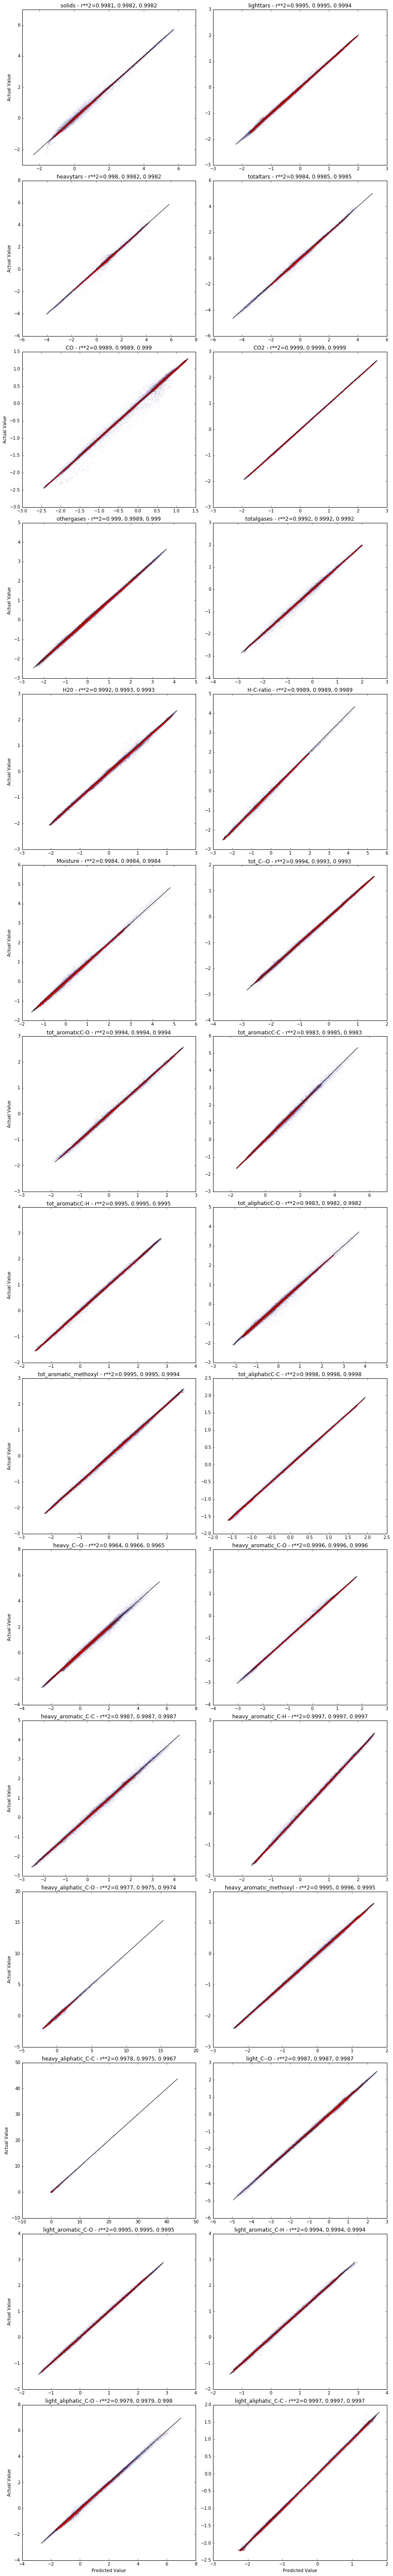

In [4]:
# Parity plots for all the individually trained networks
output_list = nets.keys()
f, ax = plt.subplots(int(round(len(output_list)/2.0)), 2, sharex=False,
                     sharey=False, figsize=(15, 3.5*len(output_list)))
ax = ax.ravel()

for key in output_list:
    title = Y_COLUMNS[key]
    net = nets[key]
    pplot_one_output(ax, net, x_train, y_train, x_test, y_test, key, title)
    
ax[len(output_list)-1].set_xlabel('Predicted Value')
ax[len(output_list)-2].set_xlabel('Predicted Value')
# put y-labels on the left hand subplots
for i in range(0, len(output_list), 2):
    ax[i].set_ylabel('Actual Value')
f.subplots_adjust(hspace=0.1, wspace=0.1)

In [6]:
solids = pd.DataFrame(np.stack((nets[0].predict(x_train).ravel(),
                                      y_train[:, 0]), axis=1))
solids.describe()

,0,1
count,200000.000000,2.000000e+05
mean,-0.008922,-4.318514e-07
std,0.998398,1.000003e+00
min,-1.740876,-2.347065e+00
25%,-0.810353,-8.016636e-01
50%,-0.148452,-1.349421e-01
75%,0.416619,4.252770e-01
max,5.747068,5.724301e+00


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x143bf3750>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x11048f7d0>]], dtype=object)

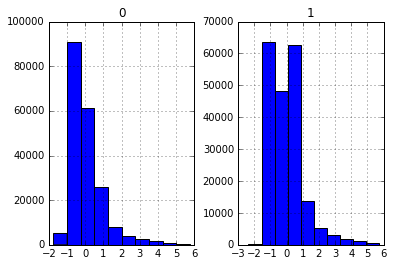

In [8]:
solids.hist()

In [9]:
ltars = pd.DataFrame(np.stack((nets[1].predict(x_train).ravel(),
                                      y_train[:, 1]), axis=1))
ltars.describe()

,0,1
count,200000.000000,2.000000e+05
mean,-0.006611,-5.141621e-08
std,0.999753,1.000002e+00
min,-2.251080,-2.199614e+00
25%,-0.827959,-8.218006e-01
50%,-0.085634,-7.334324e-02
75%,0.819292,8.248845e-01
max,2.050065,2.029100e+00


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1436874d0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x145c85d90>]], dtype=object)

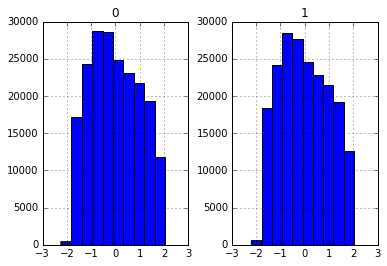

In [10]:
ltars.hist()

In [5]:
# R squared for single nets and full_net
r_squared = calc_r_squared(nets, x_train, y_train, x_test, y_test)
print_r_squared(r_squared)

r_squared_full = calc_r_squared(full_net, x_train, y_train, x_test, y_test)
print_r_squared(r_squared_full, 'Complete net')

 R**2 values for training, validation, and test sets

CO                          :   0.99893     0.9989      0.999
CO2                         :   0.99991    0.99992    0.99992
H-C-ratio                   :   0.99888    0.99888    0.99888
H20                         :   0.99924    0.99928    0.99926
Moisture                    :   0.99838    0.99844    0.99836
heavy_C--O                  :   0.99643    0.99663     0.9965
heavy_aliphatic_C-C         :   0.99778    0.99751     0.9967
heavy_aliphatic_C-O         :   0.99767    0.99745    0.99744
heavy_aromatic_C-C          :   0.99869    0.99875    0.99871
heavy_aromatic_C-H          :   0.99966    0.99966    0.99966
heavy_aromatic_C-O          :   0.99957    0.99963     0.9996
heavy_aromatic_methoxyl     :   0.99951    0.99955    0.99953
heavytars                   :   0.99804    0.99816    0.99816
light_C--O                  :   0.99869    0.99865    0.99869
light_aliphatic_C-C         :   0.99974    0.99975    0.99974
light_aliphatic_

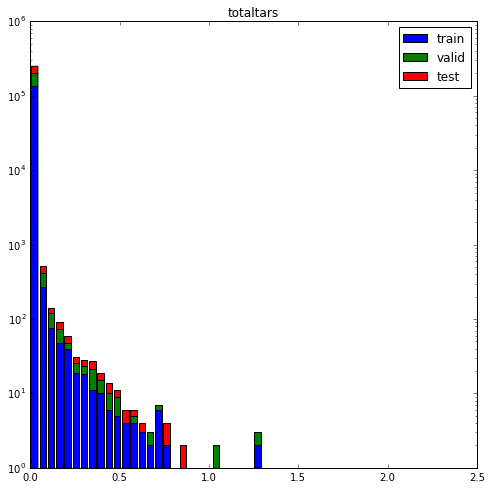

In [12]:
# Plot a histogram for a single output measure
f, ax = plt.subplots(figsize=(8, 8))
col = 3
net = nets[col]
Xt, Xv, yt, yv = net.train_split(x_train, y_train[:, col], net)
ytpred = net.predict(Xt)
yvpred = net.predict(Xv)
ytestpred = net.predict(x_test)
hplot_one_output(yt, yv, y_test[:, col], ytpred, yvpred, ytestpred,
                 Y_COLUMNS[col], ax)

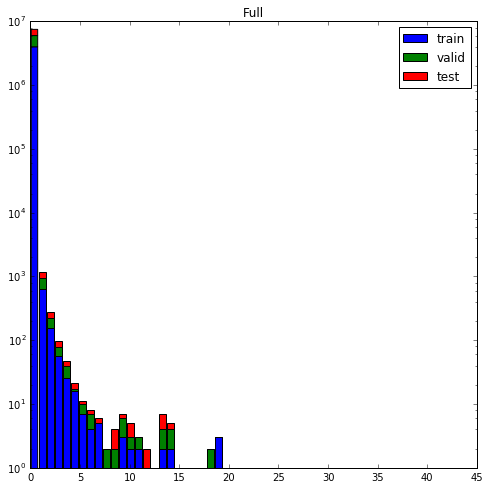

In [9]:
# Plot a histogram for the full network
f, ax = plt.subplots(figsize=(8, 8))
net = full_net['all']
Xt, Xv, yt, yv = net.train_split(x_train, y_train, net)
ytpred = net.predict(Xt)
yvpred = net.predict(Xv)
ytestpred = net.predict(x_test)
hplot_one_output(yt.flatten(), yv.flatten(), y_test.flatten(),
                 ytpred.flatten(), yvpred.flatten(), ytestpred.flatten(),
                 'Full', ax)

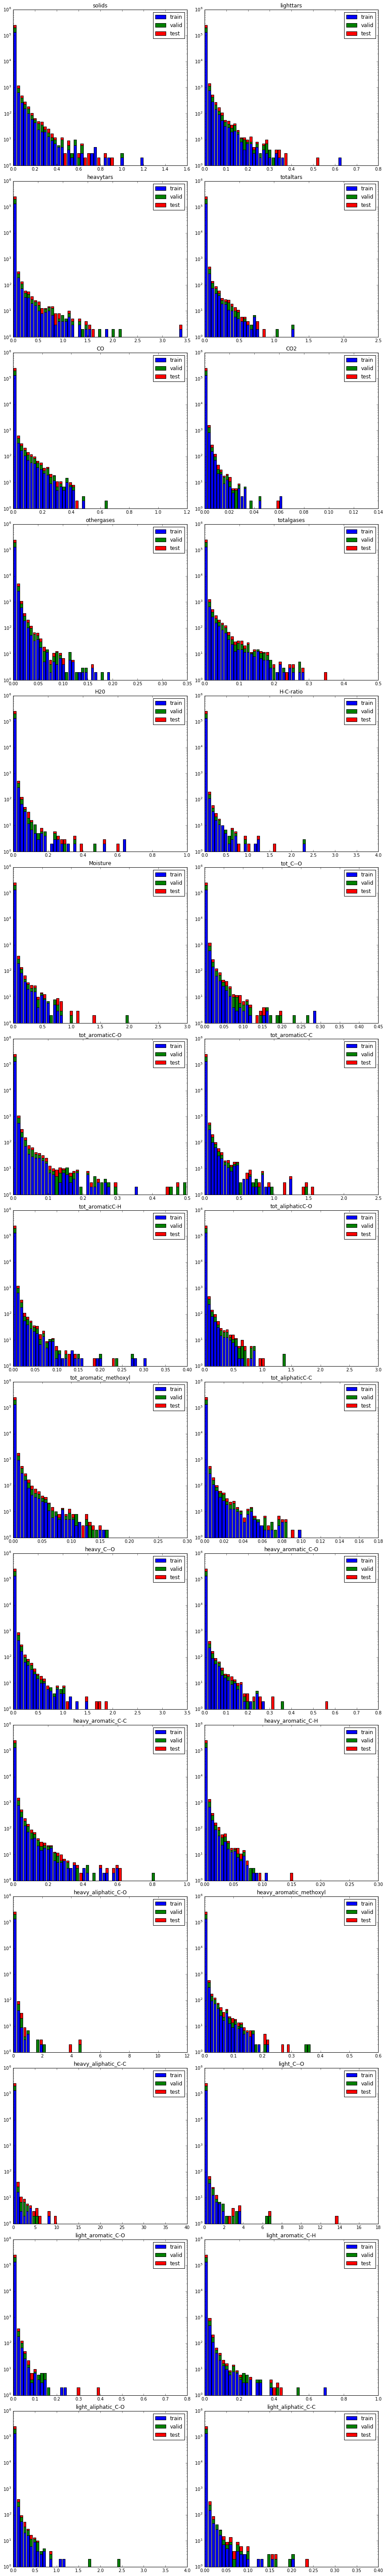

In [8]:
# Plot histograms for all the individually trained networks
# Note this cell takes a long time to evaluate
output_list = nets.keys()
f, ax = plt.subplots(int(round(len(output_list)/2.0)), 2,
                     figsize=(15, 3.5*len(output_list)))
ax = ax.ravel()

for key in output_list:
    net = nets[key]
    Xt, Xv, yt, yv = net.train_split(x_train, y_train[:, key], net)
    ytpred = net.predict(Xt)
    yvpred = net.predict(Xv)
    ytestpred = net.predict(x_test)
    hplot_one_output(yt, yv, y_test[:, key], ytpred, yvpred, ytestpred,
                     Y_COLUMNS[key], ax, key)
f.subplots_adjust(hspace=0.1, wspace=0.1)
    